In [1]:
import gym
import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent
from replay_memory import ReplayMemory

seed=0  
env = gym.make('AntBulletEnv-v0')

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import os
os.environ['PYTHONHASHSEED']=str(seed)

np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=256

LEARNING_RATE=0.0001 
eval=True  ## 
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# alpha=0.2  # relative importance of the entropy
# gamma=0.99  # discount factor 
# tau=0.005  # target smoothing coefficient(τ)

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        device=device, hidden_size=256, seed=seed, \
        lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(seed, replay_size)

print('device: ', device)
print('state dim: ', env.observation_space.shape[0])
print('action dim: ', env.action_space)
print('leraning rate: ', LEARNING_RATE)

current_dir=d:\users\user\anaconda2_02aug2019\envs\ml-agents\lib\site-packages\pybullet_envs\bullet
max_steps:  1000
device:  cuda:0
state dim:  28
action dim:  Box(8,)
leraning rate:  0.0001


In [2]:
def save(agent, directory, filename, episode, reward):
    torch.save(agent.policy.state_dict(), \
               '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), \
               '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))

In [3]:
import time
from  collections  import deque

def sac_train(max_steps):

    total_numsteps = 0
    updates = 0
    num_episodes = 10000
    updates=0

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    
    for i_episode in range(num_episodes): 
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):    
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)

                updates += 1

            next_state, reward, done, _ = env.step(action) # Step
            episode_steps += 1
            total_numsteps += 1
            episode_reward += reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask) # Append transition to memory

            state = next_state
            
            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        if i_episode % 20 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_ant_lr0001-sc2500', 'weights', str(i_episode), str(reward_round))

        s =  (int)(time.time() - time_start)
            
        print("Ep.: {}, Total Steps: {}, Ep.Steps: {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}".\
            format(i_episode, total_numsteps, episode_steps, episode_reward, avg_score, \
                  s//3600, s%3600//60, s%60))

                    
        if (avg_score > 2500.0):
            print('Solved environment with Avg Score:  ', avg_score)
            break;
            
    return scores_array, avg_scores_array 

scores, avg_scores = sac_train(max_steps=max_steps)

Ep.: 0, Total Steps: 1000, Ep.Steps: 1000, Score: 499.88, Avg.Score: 499.88, Time: 00:00:34
Ep.: 1, Total Steps: 2000, Ep.Steps: 1000, Score: 508.91, Avg.Score: 504.39, Time: 00:01:22
Ep.: 2, Total Steps: 3000, Ep.Steps: 1000, Score: 492.44, Avg.Score: 500.41, Time: 00:02:08
Ep.: 3, Total Steps: 3570, Ep.Steps: 570, Score: 271.86, Avg.Score: 443.27, Time: 00:02:35
Ep.: 4, Total Steps: 3607, Ep.Steps: 37, Score: 14.62, Avg.Score: 357.54, Time: 00:02:36
Ep.: 5, Total Steps: 4607, Ep.Steps: 1000, Score: 482.79, Avg.Score: 378.41, Time: 00:03:23
Ep.: 6, Total Steps: 5607, Ep.Steps: 1000, Score: 532.57, Avg.Score: 400.44, Time: 00:04:10
Ep.: 7, Total Steps: 6607, Ep.Steps: 1000, Score: 388.60, Avg.Score: 398.96, Time: 00:04:56
Ep.: 8, Total Steps: 6757, Ep.Steps: 150, Score: 65.42, Avg.Score: 361.90, Time: 00:05:03
Ep.: 9, Total Steps: 7757, Ep.Steps: 1000, Score: 479.69, Avg.Score: 373.68, Time: 00:05:50
Ep.: 10, Total Steps: 8757, Ep.Steps: 1000, Score: 484.56, Avg.Score: 383.76, Time: 00

Ep.: 89, Total Steps: 54049, Ep.Steps: 20, Score: 3.44, Avg.Score: 251.25, Time: 00:43:54
Ep.: 90, Total Steps: 54069, Ep.Steps: 20, Score: 3.84, Avg.Score: 248.53, Time: 00:43:55
Ep.: 91, Total Steps: 54089, Ep.Steps: 20, Score: 3.31, Avg.Score: 245.87, Time: 00:43:57
Ep.: 92, Total Steps: 54119, Ep.Steps: 30, Score: 6.98, Avg.Score: 243.30, Time: 00:43:58
Ep.: 93, Total Steps: 55119, Ep.Steps: 1000, Score: 520.20, Avg.Score: 246.25, Time: 00:44:49
Ep.: 94, Total Steps: 56119, Ep.Steps: 1000, Score: 593.81, Avg.Score: 249.90, Time: 00:45:41
Ep.: 95, Total Steps: 57119, Ep.Steps: 1000, Score: 392.01, Avg.Score: 251.38, Time: 00:46:31
Ep.: 96, Total Steps: 57667, Ep.Steps: 548, Score: 267.55, Avg.Score: 251.55, Time: 00:46:59
Ep.: 97, Total Steps: 58667, Ep.Steps: 1000, Score: 498.70, Avg.Score: 254.07, Time: 00:47:58
Ep.: 98, Total Steps: 59667, Ep.Steps: 1000, Score: 330.62, Avg.Score: 254.85, Time: 00:48:47
Ep.: 99, Total Steps: 60667, Ep.Steps: 1000, Score: 371.51, Avg.Score: 256.01

Ep.: 177, Total Steps: 103849, Ep.Steps: 1000, Score: 623.78, Avg.Score: 219.24, Time: 01:34:04
Ep.: 178, Total Steps: 104849, Ep.Steps: 1000, Score: 381.93, Avg.Score: 219.55, Time: 01:35:11
Ep.: 179, Total Steps: 105849, Ep.Steps: 1000, Score: 513.94, Avg.Score: 221.33, Time: 01:36:11
Ep.: 180, Total Steps: 106849, Ep.Steps: 1000, Score: 355.38, Avg.Score: 224.87, Time: 01:37:11
Ep.: 181, Total Steps: 107849, Ep.Steps: 1000, Score: 438.42, Avg.Score: 229.22, Time: 01:38:12
Ep.: 182, Total Steps: 108849, Ep.Steps: 1000, Score: 416.07, Avg.Score: 233.34, Time: 01:39:12
Ep.: 183, Total Steps: 109849, Ep.Steps: 1000, Score: 695.17, Avg.Score: 240.28, Time: 01:40:12
Ep.: 184, Total Steps: 110849, Ep.Steps: 1000, Score: 376.05, Avg.Score: 244.02, Time: 01:41:13
Ep.: 185, Total Steps: 111849, Ep.Steps: 1000, Score: 396.50, Avg.Score: 247.95, Time: 01:42:14
Ep.: 186, Total Steps: 112849, Ep.Steps: 1000, Score: 372.50, Avg.Score: 251.64, Time: 01:43:13
Ep.: 187, Total Steps: 113849, Ep.Steps:

Ep.: 264, Total Steps: 151168, Ep.Steps: 1000, Score: 530.68, Avg.Score: 283.58, Time: 02:20:24
Ep.: 265, Total Steps: 152168, Ep.Steps: 1000, Score: 372.38, Avg.Score: 284.09, Time: 02:21:24
Ep.: 266, Total Steps: 153168, Ep.Steps: 1000, Score: 369.91, Avg.Score: 284.11, Time: 02:22:26
Ep.: 267, Total Steps: 154168, Ep.Steps: 1000, Score: 537.91, Avg.Score: 283.51, Time: 02:23:26
Ep.: 268, Total Steps: 155168, Ep.Steps: 1000, Score: 459.70, Avg.Score: 283.45, Time: 02:24:24
Ep.: 269, Total Steps: 156168, Ep.Steps: 1000, Score: 422.58, Avg.Score: 283.53, Time: 02:25:18
Ep.: 270, Total Steps: 157168, Ep.Steps: 1000, Score: 376.67, Avg.Score: 281.47, Time: 02:26:12
Ep.: 271, Total Steps: 158168, Ep.Steps: 1000, Score: 558.61, Avg.Score: 283.22, Time: 02:27:06
Ep.: 272, Total Steps: 159168, Ep.Steps: 1000, Score: 605.86, Avg.Score: 285.72, Time: 02:27:59
Ep.: 273, Total Steps: 160168, Ep.Steps: 1000, Score: 454.87, Avg.Score: 285.47, Time: 02:28:53
Ep.: 274, Total Steps: 161168, Ep.Steps:

Ep.: 350, Total Steps: 215781, Ep.Steps: 20, Score: 3.06, Avg.Score: 381.71, Time: 03:24:02
Ep.: 351, Total Steps: 215801, Ep.Steps: 20, Score: 2.84, Avg.Score: 375.88, Time: 03:24:03
Ep.: 352, Total Steps: 215821, Ep.Steps: 20, Score: 3.29, Avg.Score: 375.85, Time: 03:24:04
Ep.: 353, Total Steps: 215841, Ep.Steps: 20, Score: 3.96, Avg.Score: 371.92, Time: 03:24:05
Ep.: 354, Total Steps: 215861, Ep.Steps: 20, Score: 4.00, Avg.Score: 366.87, Time: 03:24:06
Ep.: 355, Total Steps: 215881, Ep.Steps: 20, Score: 4.80, Avg.Score: 363.45, Time: 03:24:08
Ep.: 356, Total Steps: 215901, Ep.Steps: 20, Score: 3.91, Avg.Score: 358.45, Time: 03:24:09
Ep.: 357, Total Steps: 215921, Ep.Steps: 20, Score: 5.44, Avg.Score: 353.55, Time: 03:24:10
Ep.: 358, Total Steps: 216921, Ep.Steps: 1000, Score: 615.05, Avg.Score: 354.25, Time: 03:25:10
Ep.: 359, Total Steps: 217275, Ep.Steps: 354, Score: 198.58, Avg.Score: 352.25, Time: 03:25:32
Ep.: 360, Total Steps: 218275, Ep.Steps: 1000, Score: 350.69, Avg.Score: 

Ep.: 437, Total Steps: 270598, Ep.Steps: 1000, Score: 525.56, Avg.Score: 339.67, Time: 04:25:34
Ep.: 438, Total Steps: 270618, Ep.Steps: 20, Score: 5.44, Avg.Score: 339.67, Time: 04:25:35
Ep.: 439, Total Steps: 270638, Ep.Steps: 20, Score: 6.35, Avg.Score: 337.21, Time: 04:25:37
Ep.: 440, Total Steps: 271375, Ep.Steps: 737, Score: 404.10, Avg.Score: 335.49, Time: 04:26:29
Ep.: 441, Total Steps: 272375, Ep.Steps: 1000, Score: 732.91, Avg.Score: 341.58, Time: 04:27:40
Ep.: 442, Total Steps: 273375, Ep.Steps: 1000, Score: 676.61, Avg.Score: 343.46, Time: 04:28:52
Ep.: 443, Total Steps: 274375, Ep.Steps: 1000, Score: 478.74, Avg.Score: 343.61, Time: 04:30:03
Ep.: 444, Total Steps: 275375, Ep.Steps: 1000, Score: 566.65, Avg.Score: 343.71, Time: 04:31:15
Ep.: 445, Total Steps: 276375, Ep.Steps: 1000, Score: 644.96, Avg.Score: 349.50, Time: 04:32:26
Ep.: 446, Total Steps: 277375, Ep.Steps: 1000, Score: 675.85, Avg.Score: 349.76, Time: 04:33:38
Ep.: 447, Total Steps: 278375, Ep.Steps: 1000, Sc

Ep.: 523, Total Steps: 341792, Ep.Steps: 1000, Score: 586.16, Avg.Score: 452.48, Time: 05:33:20
Ep.: 524, Total Steps: 342792, Ep.Steps: 1000, Score: 738.47, Avg.Score: 459.61, Time: 05:34:16
Ep.: 525, Total Steps: 343792, Ep.Steps: 1000, Score: 631.41, Avg.Score: 460.77, Time: 05:35:10
Ep.: 526, Total Steps: 344792, Ep.Steps: 1000, Score: 650.37, Avg.Score: 467.22, Time: 05:36:04
Ep.: 527, Total Steps: 345792, Ep.Steps: 1000, Score: 487.91, Avg.Score: 472.03, Time: 05:36:58
Ep.: 528, Total Steps: 346792, Ep.Steps: 1000, Score: 478.23, Avg.Score: 476.76, Time: 05:37:55
Ep.: 529, Total Steps: 347792, Ep.Steps: 1000, Score: 408.17, Avg.Score: 476.80, Time: 05:38:51
Ep.: 530, Total Steps: 348792, Ep.Steps: 1000, Score: 507.75, Avg.Score: 475.31, Time: 05:39:47
Ep.: 531, Total Steps: 349792, Ep.Steps: 1000, Score: 598.97, Avg.Score: 479.86, Time: 05:40:39
Ep.: 532, Total Steps: 350792, Ep.Steps: 1000, Score: 721.92, Avg.Score: 487.04, Time: 05:41:42
Ep.: 533, Total Steps: 351792, Ep.Steps:

Ep.: 609, Total Steps: 412418, Ep.Steps: 1000, Score: 573.25, Avg.Score: 491.74, Time: 06:43:17
Ep.: 610, Total Steps: 413418, Ep.Steps: 1000, Score: 632.09, Avg.Score: 492.18, Time: 06:44:11
Ep.: 611, Total Steps: 414418, Ep.Steps: 1000, Score: 766.70, Avg.Score: 495.43, Time: 06:45:02
Ep.: 612, Total Steps: 415418, Ep.Steps: 1000, Score: 654.96, Avg.Score: 497.58, Time: 06:45:54
Ep.: 613, Total Steps: 416237, Ep.Steps: 819, Score: 532.23, Avg.Score: 498.14, Time: 06:46:36
Ep.: 614, Total Steps: 417237, Ep.Steps: 1000, Score: 674.89, Avg.Score: 497.48, Time: 06:47:29
Ep.: 615, Total Steps: 418237, Ep.Steps: 1000, Score: 616.13, Avg.Score: 498.58, Time: 06:48:23
Ep.: 616, Total Steps: 419237, Ep.Steps: 1000, Score: 488.55, Avg.Score: 496.28, Time: 06:49:18
Ep.: 617, Total Steps: 419580, Ep.Steps: 343, Score: 196.88, Avg.Score: 498.04, Time: 06:49:36
Ep.: 618, Total Steps: 420364, Ep.Steps: 784, Score: 471.02, Avg.Score: 502.74, Time: 06:50:16
Ep.: 619, Total Steps: 421364, Ep.Steps: 10

Ep.: 695, Total Steps: 494897, Ep.Steps: 1000, Score: 709.41, Avg.Score: 588.43, Time: 07:54:35
Ep.: 696, Total Steps: 495897, Ep.Steps: 1000, Score: 643.21, Avg.Score: 587.05, Time: 07:55:29
Ep.: 697, Total Steps: 496897, Ep.Steps: 1000, Score: 631.33, Avg.Score: 593.31, Time: 07:56:25
Ep.: 698, Total Steps: 497897, Ep.Steps: 1000, Score: 788.45, Avg.Score: 593.68, Time: 07:57:22
Ep.: 699, Total Steps: 498897, Ep.Steps: 1000, Score: 739.85, Avg.Score: 601.04, Time: 07:58:20
Ep.: 700, Total Steps: 499897, Ep.Steps: 1000, Score: 697.78, Avg.Score: 607.99, Time: 07:59:17
Ep.: 701, Total Steps: 500897, Ep.Steps: 1000, Score: 758.60, Avg.Score: 615.55, Time: 08:00:18
Ep.: 702, Total Steps: 501897, Ep.Steps: 1000, Score: 708.83, Avg.Score: 617.52, Time: 08:01:13
Ep.: 703, Total Steps: 502897, Ep.Steps: 1000, Score: 695.27, Avg.Score: 617.77, Time: 08:02:05
Ep.: 704, Total Steps: 503897, Ep.Steps: 1000, Score: 751.13, Avg.Score: 620.17, Time: 08:02:59
Ep.: 705, Total Steps: 504897, Ep.Steps:

Ep.: 781, Total Steps: 580897, Ep.Steps: 1000, Score: 735.45, Avg.Score: 692.06, Time: 09:12:52
Ep.: 782, Total Steps: 581897, Ep.Steps: 1000, Score: 582.90, Avg.Score: 691.77, Time: 09:13:43
Ep.: 783, Total Steps: 582897, Ep.Steps: 1000, Score: 816.36, Avg.Score: 692.88, Time: 09:14:34
Ep.: 784, Total Steps: 583897, Ep.Steps: 1000, Score: 884.17, Avg.Score: 695.93, Time: 09:15:25
Ep.: 785, Total Steps: 584897, Ep.Steps: 1000, Score: 798.28, Avg.Score: 696.94, Time: 09:16:16
Ep.: 786, Total Steps: 585897, Ep.Steps: 1000, Score: 816.59, Avg.Score: 699.90, Time: 09:17:06
Ep.: 787, Total Steps: 586897, Ep.Steps: 1000, Score: 651.38, Avg.Score: 702.11, Time: 09:17:57
Ep.: 788, Total Steps: 587897, Ep.Steps: 1000, Score: 781.19, Avg.Score: 704.46, Time: 09:18:47
Ep.: 789, Total Steps: 588897, Ep.Steps: 1000, Score: 727.67, Avg.Score: 703.72, Time: 09:19:37
Ep.: 790, Total Steps: 589897, Ep.Steps: 1000, Score: 618.77, Avg.Score: 703.99, Time: 09:20:28
Ep.: 791, Total Steps: 590897, Ep.Steps:

Ep.: 867, Total Steps: 666122, Ep.Steps: 1000, Score: 647.56, Avg.Score: 740.02, Time: 10:24:32
Ep.: 868, Total Steps: 667122, Ep.Steps: 1000, Score: 925.12, Avg.Score: 741.66, Time: 10:25:23
Ep.: 869, Total Steps: 668122, Ep.Steps: 1000, Score: 855.41, Avg.Score: 742.38, Time: 10:26:13
Ep.: 870, Total Steps: 669122, Ep.Steps: 1000, Score: 915.71, Avg.Score: 744.72, Time: 10:27:03
Ep.: 871, Total Steps: 670122, Ep.Steps: 1000, Score: 732.80, Avg.Score: 746.13, Time: 10:27:53
Ep.: 872, Total Steps: 671122, Ep.Steps: 1000, Score: 673.00, Avg.Score: 745.67, Time: 10:28:43
Ep.: 873, Total Steps: 672122, Ep.Steps: 1000, Score: 852.02, Avg.Score: 745.40, Time: 10:29:33
Ep.: 874, Total Steps: 673122, Ep.Steps: 1000, Score: 704.07, Avg.Score: 744.87, Time: 10:30:24
Ep.: 875, Total Steps: 674122, Ep.Steps: 1000, Score: 747.43, Avg.Score: 744.55, Time: 10:31:14
Ep.: 876, Total Steps: 675122, Ep.Steps: 1000, Score: 767.52, Avg.Score: 743.41, Time: 10:32:04
Ep.: 877, Total Steps: 676122, Ep.Steps:

Ep.: 953, Total Steps: 752122, Ep.Steps: 1000, Score: 736.40, Avg.Score: 775.82, Time: 11:36:27
Ep.: 954, Total Steps: 753122, Ep.Steps: 1000, Score: 863.09, Avg.Score: 778.29, Time: 11:37:17
Ep.: 955, Total Steps: 754122, Ep.Steps: 1000, Score: 991.10, Avg.Score: 779.60, Time: 11:38:07
Ep.: 956, Total Steps: 755122, Ep.Steps: 1000, Score: 929.99, Avg.Score: 780.22, Time: 11:38:57
Ep.: 957, Total Steps: 756122, Ep.Steps: 1000, Score: 805.40, Avg.Score: 780.67, Time: 11:39:47
Ep.: 958, Total Steps: 757122, Ep.Steps: 1000, Score: 950.53, Avg.Score: 784.02, Time: 11:40:37
Ep.: 959, Total Steps: 758122, Ep.Steps: 1000, Score: 637.41, Avg.Score: 783.45, Time: 11:41:27
Ep.: 960, Total Steps: 759122, Ep.Steps: 1000, Score: 803.93, Avg.Score: 785.43, Time: 11:42:17
Ep.: 961, Total Steps: 760122, Ep.Steps: 1000, Score: 936.31, Avg.Score: 785.40, Time: 11:43:07
Ep.: 962, Total Steps: 761122, Ep.Steps: 1000, Score: 790.37, Avg.Score: 786.00, Time: 11:43:57
Ep.: 963, Total Steps: 762122, Ep.Steps:

Ep.: 1038, Total Steps: 837122, Ep.Steps: 1000, Score: 1212.49, Avg.Score: 910.51, Time: 12:50:57
Ep.: 1039, Total Steps: 838122, Ep.Steps: 1000, Score: 813.22, Avg.Score: 912.74, Time: 12:51:49
Ep.: 1040, Total Steps: 839122, Ep.Steps: 1000, Score: 1147.63, Avg.Score: 915.81, Time: 12:52:40
Ep.: 1041, Total Steps: 840122, Ep.Steps: 1000, Score: 962.85, Avg.Score: 917.39, Time: 12:53:33
Ep.: 1042, Total Steps: 841122, Ep.Steps: 1000, Score: 1217.76, Avg.Score: 921.92, Time: 12:54:24
Ep.: 1043, Total Steps: 842122, Ep.Steps: 1000, Score: 1207.47, Avg.Score: 926.65, Time: 12:55:15
Ep.: 1044, Total Steps: 843122, Ep.Steps: 1000, Score: 1267.63, Avg.Score: 931.59, Time: 12:56:06
Ep.: 1045, Total Steps: 844122, Ep.Steps: 1000, Score: 880.24, Avg.Score: 932.45, Time: 12:56:56
Ep.: 1046, Total Steps: 845122, Ep.Steps: 1000, Score: 1337.95, Avg.Score: 937.39, Time: 12:57:46
Ep.: 1047, Total Steps: 846122, Ep.Steps: 1000, Score: 889.93, Avg.Score: 938.56, Time: 12:58:37
Ep.: 1048, Total Steps: 

Ep.: 1122, Total Steps: 921122, Ep.Steps: 1000, Score: 1469.33, Avg.Score: 1245.02, Time: 14:03:22
Ep.: 1123, Total Steps: 922122, Ep.Steps: 1000, Score: 1378.09, Avg.Score: 1246.30, Time: 14:04:12
Ep.: 1124, Total Steps: 923122, Ep.Steps: 1000, Score: 1501.90, Avg.Score: 1252.48, Time: 14:05:03
Ep.: 1125, Total Steps: 924122, Ep.Steps: 1000, Score: 1597.93, Avg.Score: 1258.81, Time: 14:05:53
Ep.: 1126, Total Steps: 925122, Ep.Steps: 1000, Score: 1508.53, Avg.Score: 1262.11, Time: 14:06:45
Ep.: 1127, Total Steps: 926122, Ep.Steps: 1000, Score: 1523.28, Avg.Score: 1267.53, Time: 14:07:36
Ep.: 1128, Total Steps: 927122, Ep.Steps: 1000, Score: 1100.20, Avg.Score: 1270.40, Time: 14:08:27
Ep.: 1129, Total Steps: 928122, Ep.Steps: 1000, Score: 1596.01, Avg.Score: 1277.26, Time: 14:09:22
Ep.: 1130, Total Steps: 929122, Ep.Steps: 1000, Score: 1484.50, Avg.Score: 1281.49, Time: 14:10:13
Ep.: 1131, Total Steps: 930122, Ep.Steps: 1000, Score: 1609.89, Avg.Score: 1288.06, Time: 14:11:13
Ep.: 1132,

Ep.: 1205, Total Steps: 1004122, Ep.Steps: 1000, Score: 1635.96, Avg.Score: 1589.12, Time: 15:16:37
Ep.: 1206, Total Steps: 1005122, Ep.Steps: 1000, Score: 1564.70, Avg.Score: 1590.79, Time: 15:17:36
Ep.: 1207, Total Steps: 1006122, Ep.Steps: 1000, Score: 1597.87, Avg.Score: 1591.73, Time: 15:18:33
Ep.: 1208, Total Steps: 1007122, Ep.Steps: 1000, Score: 1651.89, Avg.Score: 1594.54, Time: 15:19:31
Ep.: 1209, Total Steps: 1008122, Ep.Steps: 1000, Score: 1708.88, Avg.Score: 1596.85, Time: 15:20:29
Ep.: 1210, Total Steps: 1009122, Ep.Steps: 1000, Score: 1744.59, Avg.Score: 1599.58, Time: 15:21:25
Ep.: 1211, Total Steps: 1010122, Ep.Steps: 1000, Score: 1631.19, Avg.Score: 1601.20, Time: 15:22:23
Ep.: 1212, Total Steps: 1011122, Ep.Steps: 1000, Score: 1643.36, Avg.Score: 1602.35, Time: 15:23:23
Ep.: 1213, Total Steps: 1012122, Ep.Steps: 1000, Score: 1707.81, Avg.Score: 1605.87, Time: 15:24:21
Ep.: 1214, Total Steps: 1013122, Ep.Steps: 1000, Score: 1640.97, Avg.Score: 1608.03, Time: 15:25:19


Ep.: 1287, Total Steps: 1086122, Ep.Steps: 1000, Score: 1745.87, Avg.Score: 1707.91, Time: 16:37:23
Ep.: 1288, Total Steps: 1087122, Ep.Steps: 1000, Score: 1737.50, Avg.Score: 1709.04, Time: 16:38:16
Ep.: 1289, Total Steps: 1088122, Ep.Steps: 1000, Score: 1730.80, Avg.Score: 1708.74, Time: 16:39:08
Ep.: 1290, Total Steps: 1089122, Ep.Steps: 1000, Score: 1760.39, Avg.Score: 1709.42, Time: 16:40:01
Ep.: 1291, Total Steps: 1090122, Ep.Steps: 1000, Score: 1757.03, Avg.Score: 1710.18, Time: 16:40:52
Ep.: 1292, Total Steps: 1091122, Ep.Steps: 1000, Score: 1791.80, Avg.Score: 1712.19, Time: 16:41:43
Ep.: 1293, Total Steps: 1092122, Ep.Steps: 1000, Score: 1786.20, Avg.Score: 1713.19, Time: 16:42:34
Ep.: 1294, Total Steps: 1093122, Ep.Steps: 1000, Score: 1769.95, Avg.Score: 1715.11, Time: 16:43:25
Ep.: 1295, Total Steps: 1094122, Ep.Steps: 1000, Score: 1784.55, Avg.Score: 1716.98, Time: 16:44:16
Ep.: 1296, Total Steps: 1095122, Ep.Steps: 1000, Score: 1779.02, Avg.Score: 1718.22, Time: 16:45:07


Ep.: 1369, Total Steps: 1168122, Ep.Steps: 1000, Score: 2051.66, Avg.Score: 1859.07, Time: 17:47:19
Ep.: 1370, Total Steps: 1169122, Ep.Steps: 1000, Score: 1921.62, Avg.Score: 1861.00, Time: 17:48:09
Ep.: 1371, Total Steps: 1170122, Ep.Steps: 1000, Score: 1998.59, Avg.Score: 1862.89, Time: 17:49:00
Ep.: 1372, Total Steps: 1171122, Ep.Steps: 1000, Score: 1988.25, Avg.Score: 1865.06, Time: 17:49:50
Ep.: 1373, Total Steps: 1172122, Ep.Steps: 1000, Score: 2033.61, Avg.Score: 1867.46, Time: 17:50:40
Ep.: 1374, Total Steps: 1173122, Ep.Steps: 1000, Score: 1989.83, Avg.Score: 1869.47, Time: 17:51:31
Ep.: 1375, Total Steps: 1174122, Ep.Steps: 1000, Score: 2068.84, Avg.Score: 1872.53, Time: 17:52:21
Ep.: 1376, Total Steps: 1175122, Ep.Steps: 1000, Score: 2023.74, Avg.Score: 1875.07, Time: 17:53:11
Ep.: 1377, Total Steps: 1176122, Ep.Steps: 1000, Score: 1982.09, Avg.Score: 1877.52, Time: 17:54:07
Ep.: 1378, Total Steps: 1177122, Ep.Steps: 1000, Score: 2070.44, Avg.Score: 1880.74, Time: 17:55:04


Ep.: 1451, Total Steps: 1250122, Ep.Steps: 1000, Score: 2143.05, Avg.Score: 2048.78, Time: 18:58:13
Ep.: 1452, Total Steps: 1251122, Ep.Steps: 1000, Score: 2147.30, Avg.Score: 2051.55, Time: 18:59:03
Ep.: 1453, Total Steps: 1252122, Ep.Steps: 1000, Score: 2153.09, Avg.Score: 2053.55, Time: 18:59:53
Ep.: 1454, Total Steps: 1253122, Ep.Steps: 1000, Score: 2134.11, Avg.Score: 2055.82, Time: 19:00:44
Ep.: 1455, Total Steps: 1254122, Ep.Steps: 1000, Score: 2191.32, Avg.Score: 2058.11, Time: 19:01:34
Ep.: 1456, Total Steps: 1255122, Ep.Steps: 1000, Score: 2220.43, Avg.Score: 2061.03, Time: 19:02:25
Ep.: 1457, Total Steps: 1256122, Ep.Steps: 1000, Score: 2157.49, Avg.Score: 2062.34, Time: 19:03:15
Ep.: 1458, Total Steps: 1257122, Ep.Steps: 1000, Score: 2183.65, Avg.Score: 2064.30, Time: 19:04:05
Ep.: 1459, Total Steps: 1258122, Ep.Steps: 1000, Score: 2158.73, Avg.Score: 2066.48, Time: 19:04:55
Ep.: 1460, Total Steps: 1259122, Ep.Steps: 1000, Score: 2150.49, Avg.Score: 2069.19, Time: 19:05:46


Ep.: 1533, Total Steps: 1332122, Ep.Steps: 1000, Score: 2266.05, Avg.Score: 2192.45, Time: 20:07:11
Ep.: 1534, Total Steps: 1333122, Ep.Steps: 1000, Score: 2267.11, Avg.Score: 2194.02, Time: 20:08:02
Ep.: 1535, Total Steps: 1334122, Ep.Steps: 1000, Score: 2255.02, Avg.Score: 2195.06, Time: 20:08:52
Ep.: 1536, Total Steps: 1335122, Ep.Steps: 1000, Score: 2244.58, Avg.Score: 2196.05, Time: 20:09:43
Ep.: 1537, Total Steps: 1336122, Ep.Steps: 1000, Score: 2246.75, Avg.Score: 2197.22, Time: 20:10:34
Ep.: 1538, Total Steps: 1337122, Ep.Steps: 1000, Score: 2226.98, Avg.Score: 2198.10, Time: 20:11:24
Ep.: 1539, Total Steps: 1338122, Ep.Steps: 1000, Score: 2277.20, Avg.Score: 2199.73, Time: 20:12:15
Ep.: 1540, Total Steps: 1339122, Ep.Steps: 1000, Score: 2220.98, Avg.Score: 2200.68, Time: 20:13:06
Ep.: 1541, Total Steps: 1340122, Ep.Steps: 1000, Score: 2289.13, Avg.Score: 2202.80, Time: 20:13:56
Ep.: 1542, Total Steps: 1341122, Ep.Steps: 1000, Score: 2279.50, Avg.Score: 2204.44, Time: 20:14:47


Ep.: 1615, Total Steps: 1414122, Ep.Steps: 1000, Score: 2212.61, Avg.Score: 2286.63, Time: 21:16:15
Ep.: 1616, Total Steps: 1415122, Ep.Steps: 1000, Score: 2367.84, Avg.Score: 2288.21, Time: 21:17:05
Ep.: 1617, Total Steps: 1416122, Ep.Steps: 1000, Score: 2381.64, Avg.Score: 2289.35, Time: 21:17:55
Ep.: 1618, Total Steps: 1417122, Ep.Steps: 1000, Score: 2350.67, Avg.Score: 2290.68, Time: 21:18:46
Ep.: 1619, Total Steps: 1418122, Ep.Steps: 1000, Score: 2270.33, Avg.Score: 2290.93, Time: 21:19:36
Ep.: 1620, Total Steps: 1419122, Ep.Steps: 1000, Score: 2361.40, Avg.Score: 2292.51, Time: 21:20:26
Ep.: 1621, Total Steps: 1420122, Ep.Steps: 1000, Score: 2300.73, Avg.Score: 2293.07, Time: 21:21:16
Ep.: 1622, Total Steps: 1421122, Ep.Steps: 1000, Score: 2352.76, Avg.Score: 2293.79, Time: 21:22:06
Ep.: 1623, Total Steps: 1422122, Ep.Steps: 1000, Score: 2288.46, Avg.Score: 2294.09, Time: 21:22:57
Ep.: 1624, Total Steps: 1423122, Ep.Steps: 1000, Score: 2321.09, Avg.Score: 2294.91, Time: 21:23:47


Ep.: 1697, Total Steps: 1496122, Ep.Steps: 1000, Score: 2414.45, Avg.Score: 2367.04, Time: 22:25:17
Ep.: 1698, Total Steps: 1497122, Ep.Steps: 1000, Score: 2418.75, Avg.Score: 2367.83, Time: 22:26:07
Ep.: 1699, Total Steps: 1498122, Ep.Steps: 1000, Score: 2390.03, Avg.Score: 2368.61, Time: 22:26:58
Ep.: 1700, Total Steps: 1499122, Ep.Steps: 1000, Score: 2400.73, Avg.Score: 2370.42, Time: 22:27:48
Ep.: 1701, Total Steps: 1500122, Ep.Steps: 1000, Score: 2363.30, Avg.Score: 2370.68, Time: 22:28:39
Ep.: 1702, Total Steps: 1501122, Ep.Steps: 1000, Score: 2291.71, Avg.Score: 2370.26, Time: 22:29:29
Ep.: 1703, Total Steps: 1502122, Ep.Steps: 1000, Score: 2405.67, Avg.Score: 2371.20, Time: 22:30:19
Ep.: 1704, Total Steps: 1503122, Ep.Steps: 1000, Score: 2410.64, Avg.Score: 2372.09, Time: 22:31:10
Ep.: 1705, Total Steps: 1504122, Ep.Steps: 1000, Score: 2405.25, Avg.Score: 2372.51, Time: 22:32:00
Ep.: 1706, Total Steps: 1505122, Ep.Steps: 1000, Score: 2423.75, Avg.Score: 2373.10, Time: 22:32:50


Ep.: 1779, Total Steps: 1578122, Ep.Steps: 1000, Score: 2563.52, Avg.Score: 2433.67, Time: 23:34:19
Ep.: 1780, Total Steps: 1579122, Ep.Steps: 1000, Score: 2582.60, Avg.Score: 2435.87, Time: 23:35:10
Ep.: 1781, Total Steps: 1580122, Ep.Steps: 1000, Score: 2600.63, Avg.Score: 2438.19, Time: 23:36:00
Ep.: 1782, Total Steps: 1581122, Ep.Steps: 1000, Score: 2609.21, Avg.Score: 2441.03, Time: 23:36:50
Ep.: 1783, Total Steps: 1582122, Ep.Steps: 1000, Score: 2577.42, Avg.Score: 2442.96, Time: 23:37:41
Ep.: 1784, Total Steps: 1583122, Ep.Steps: 1000, Score: 2560.64, Avg.Score: 2445.32, Time: 23:38:31
Ep.: 1785, Total Steps: 1584122, Ep.Steps: 1000, Score: 2612.00, Avg.Score: 2447.40, Time: 23:39:21
Ep.: 1786, Total Steps: 1585122, Ep.Steps: 1000, Score: 2557.17, Avg.Score: 2448.64, Time: 23:40:12
Ep.: 1787, Total Steps: 1586122, Ep.Steps: 1000, Score: 2587.76, Avg.Score: 2450.37, Time: 23:41:02
Ep.: 1788, Total Steps: 1587122, Ep.Steps: 1000, Score: 2559.14, Avg.Score: 2452.62, Time: 23:41:53


In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_ant_lr0001-sc2500', 'weights', 'final', str(reward_round))

length of scores:  1811 , len of avg_scores:  1811


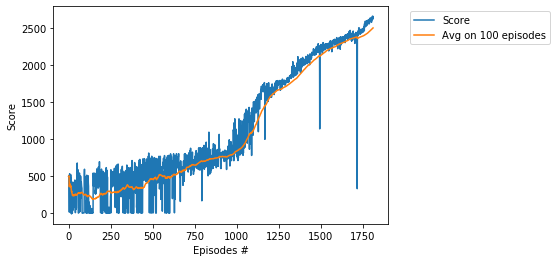

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [6]:
def play(env, agent, num_episodes):
    
    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(num_episodes + 1):
        
        state = env.reset()
        score = 0                    
        time_start = time.time()
        
        while True:
            
            action = agent.select_action(state, eval=True)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward 
            state = next_state
    
            if done:
                break
                
        s = (int)(time.time() - time_start)
        
        scores_deque.append(score)
        scores.append(score)    
        
        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60)) 
    

In [7]:
play(env=env, agent=agent, num_episodes=5)

Episode 0	Average Score: 2736.22,	Score: 2736.22 	Time: 00:00:04
Episode 1	Average Score: 2720.49,	Score: 2704.76 	Time: 00:00:04
Episode 2	Average Score: 2720.39,	Score: 2720.20 	Time: 00:00:04
Episode 3	Average Score: 2720.44,	Score: 2720.57 	Time: 00:00:04
Episode 4	Average Score: 2715.57,	Score: 2696.11 	Time: 00:00:04
Episode 5	Average Score: 2710.24,	Score: 2683.60 	Time: 00:00:04


In [9]:
env.close()

In [12]:
#env_render = gym.make('AntBulletEnv-v0', render=True)
#play(env=env_render, agent=agent, num_episodes=5)


In [13]:
#play(env=env_render, agent=agent, num_episodes=5)

In [ ]:
env_render.close()